In [1]:
import os
import glob
import torch
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme("paper")

# Global variable to store the aggregated metrics for later use
aggregated_metrics_dict = {}

# Mount Google Drive
def mount_drive():
    from google.colab import drive
    drive.mount('/content/drive')

def extract_metrics_as_dict(checkpoint):
    """Extracts metrics such as loss and channel-wise metrics from a checkpoint dictionary."""
    return {
        'train_loss': checkpoint.get('train_loss', None),
        'val_loss': checkpoint.get('val_loss', None),
        'test_loss': checkpoint.get('test_loss', None),
        'channelwise_metrics': {
            'train': checkpoint.get('train_channelwise_metrics', {}),
            'val': checkpoint.get('val_channelwise_metrics', {}),
            'test': checkpoint.get('test_channelwise_metrics', {})
        }
    }

# Function to load only required metrics without loading model weights
def load_metrics_from_checkpoint(checkpoint_file):
    """Loads only the metrics from a checkpoint file without loading model weights."""
    try:
        # Load the full checkpoint dictionary
        checkpoint = torch.load(checkpoint_file, map_location='cpu')
        # Extract only metrics
        metrics = extract_metrics_as_dict(checkpoint)
        return metrics
    except Exception as e:
        print(f"Failed to load checkpoint {checkpoint_file}: {e}")
        return None

# Load all checkpoints from a folder with progress bar
def load_all_checkpoints(folder_path):
    """Loads all checkpoints in a folder and returns a list of their metrics with a progress bar."""
    checkpoints = glob.glob(os.path.join(folder_path, "*.pth"))
    if not checkpoints:
        return None

    # Sort by epoch number and load each checkpoint with progress bar
    checkpoints.sort(key=lambda x: int(x.split('_epoch_')[-1].split('.pth')[0]))
    all_metrics = []

    print(f"Loading checkpoints from {folder_path}...")
    for checkpoint_file in tqdm(checkpoints, desc="Loading Checkpoints"):
        metrics = load_metrics_from_checkpoint(checkpoint_file)
        if metrics:
            all_metrics.append(metrics)

    return all_metrics

# Aggregate the loss and metric histories across all checkpoints with progress bar
def aggregate_histories(metrics_list):
    """Aggregates train/val/test loss and channelwise metrics across all epochs with a progress bar."""
    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    print("Aggregating histories...")
    for metrics in tqdm(metrics_list, desc="Aggregating"):
        train_losses.append(metrics['train_loss'])
        val_losses.append(metrics['val_loss'])
        test_losses.append(metrics['test_loss'])

        train_pccs.append(metrics['channelwise_metrics']['train'].get('pcc', []))
        val_pccs.append(metrics['channelwise_metrics']['val'].get('pcc', []))
        test_pccs.append(metrics['channelwise_metrics']['test'].get('pcc', []))

        train_rmses.append(metrics['channelwise_metrics']['train'].get('rmse', []))
        val_rmses.append(metrics['channelwise_metrics']['val'].get('rmse', []))
        test_rmses.append(metrics['channelwise_metrics']['test'].get('rmse', []))

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_pccs': train_pccs,
        'val_pccs': val_pccs,
        'test_pccs': test_pccs,
        'train_rmses': train_rmses,
        'val_rmses': val_rmses,
        'test_rmses': test_rmses,
    }

def plot_metrics(aggregated_metrics, folder):
    """Plots train/val/test losses and channelwise PCC and RMSE over epochs."""
    epochs = list(range(1, len(aggregated_metrics['train_losses']) + 1))
    line_styles = ['-', '--', '-.', ':']  # Define different line styles for channels

    # New color palette
    train_color = '#17becf'  # Teal blue for Train
    val_color = '#bcbd22'    # Mustard yellow for Val
    test_color = '#e377c2'   # Pastel magenta for Test

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, aggregated_metrics['train_losses'], label='Train Loss', color=train_color, linestyle=line_styles[0])
    plt.plot(epochs, aggregated_metrics['val_losses'], label='Val Loss', color=val_color, linestyle=line_styles[0])
    plt.plot(epochs, aggregated_metrics['test_losses'], label='Test Loss', color=test_color, linestyle=line_styles[0])
    plt.title(f'Losses over Epochs for {folder}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot PCCs for each channel with different line styles
    plt.figure(figsize=(10, 6))
    for i, style in enumerate(line_styles):
        if len(aggregated_metrics['train_pccs'][0]) > i:  # Only plot if there are enough channels
            plt.plot(epochs, [pcc[i] for pcc in aggregated_metrics['train_pccs']], label=f'Train PCC (Channel {i+1})', color=train_color, linestyle=style)
            plt.plot(epochs, [pcc[i] for pcc in aggregated_metrics['val_pccs']], label=f'Val PCC (Channel {i+1})', color=val_color, linestyle=style)
            plt.plot(epochs, [pcc[i] for pcc in aggregated_metrics['test_pccs']], label=f'Test PCC (Channel {i+1})', color=test_color, linestyle=style)

    plt.title(f'PCC over Epochs for {folder}')
    plt.xlabel('Epoch')
    plt.ylabel('PCC')
    plt.legend()
    plt.show()

    # Plot average PCCs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, np.mean(aggregated_metrics['train_pccs'],axis=1), label='Channelwise average Train PCC', color=train_color, linestyle='-')
    plt.plot(epochs, np.mean(aggregated_metrics['val_pccs'],axis=1), label='Channelwise average Val PCC', color=val_color, linestyle='-')
    plt.plot(epochs, np.mean(aggregated_metrics['test_pccs'],axis=1), label='Channelwise average Test PCC', color=test_color, linestyle='-')
    plt.title(f'Pearson Correlation over Epochs for {folder}')
    plt.xlabel('Epoch')
    plt.ylabel('PCC')
    plt.legend()
    plt.show()

    # Plot RMSEs for each channel with different line styles
    plt.figure(figsize=(10, 6))
    for i, style in enumerate(line_styles):
        if len(aggregated_metrics['train_rmses'][0]) > i:  # Only plot if there are enough channels
            plt.plot(epochs, [rmse[i] for rmse in aggregated_metrics['train_rmses']], label=f'Train RMSE (Channel {i+1})', color=train_color, linestyle=style)
            plt.plot(epochs, [rmse[i] for rmse in aggregated_metrics['val_rmses']], label=f'Val RMSE (Channel {i+1})', color=val_color, linestyle=style)
            plt.plot(epochs, [rmse[i] for rmse in aggregated_metrics['test_rmses']], label=f'Test RMSE (Channel {i+1})', color=test_color, linestyle=style)

    plt.title(f'RMSE over Epochs for {folder}')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    # Plot average RMSEs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, np.mean(aggregated_metrics['train_rmses'],axis=1), label='Channelwise average Train RMSE', color=train_color, linestyle='-')
    plt.plot(epochs, np.mean(aggregated_metrics['val_rmses'],axis=1), label='Channelwise average Val RMSE', color=val_color, linestyle='-')
    plt.plot(epochs, np.mean(aggregated_metrics['test_rmses'],axis=1), label='Channelwise average Test RMSE', color=test_color, linestyle='-')
    plt.title(f'RMSE over Epochs for {folder}')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

# Function to load, aggregate, and save aggregated data globally for later use
def load_and_aggregate(selected_folders):
    """Loads and aggregates metrics from the selected folders and saves the results globally."""

    global aggregated_metrics_dict

    # Process the checkpoints and aggregate metrics for each selected folder
    for folder in selected_folders:
        folder_path = os.path.join("/content/drive/MyDrive/models/", folder)
        all_metrics = load_all_checkpoints(folder_path)

        if all_metrics is not None:
            aggregated_metrics = aggregate_histories(all_metrics)
            aggregated_metrics_dict[folder] = aggregated_metrics  # Save aggregated metrics globally
            plot_metrics(aggregated_metrics, folder)  # Plot the metrics
        else:
            print(f"No checkpoints found in folder: {folder}")

# Create UI to select folders
def create_ui():
    base_path = "/content/drive/MyDrive/models/"
    model_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

    # UI to select folders
    folder_selector = widgets.SelectMultiple(
        options=model_folders,
        value=[],
        description='Model Folders',
        disabled=False,
        layout=Layout(width='80%', height='250px')  # Enlarging the widget
    )

    print_button = widgets.Button(description="Process and Aggregate Folders", layout=Layout(width='30%', height='40px'))

    def on_print_button_clicked(b):
        selected_folders = list(folder_selector.value)
        load_and_aggregate(selected_folders)

    print_button.on_click(on_print_button_clicked)

    display(folder_selector, print_button)

# Mount Google Drive and display UI for folder selection
mount_drive()
create_ui()


Output hidden; open in https://colab.research.google.com to view.

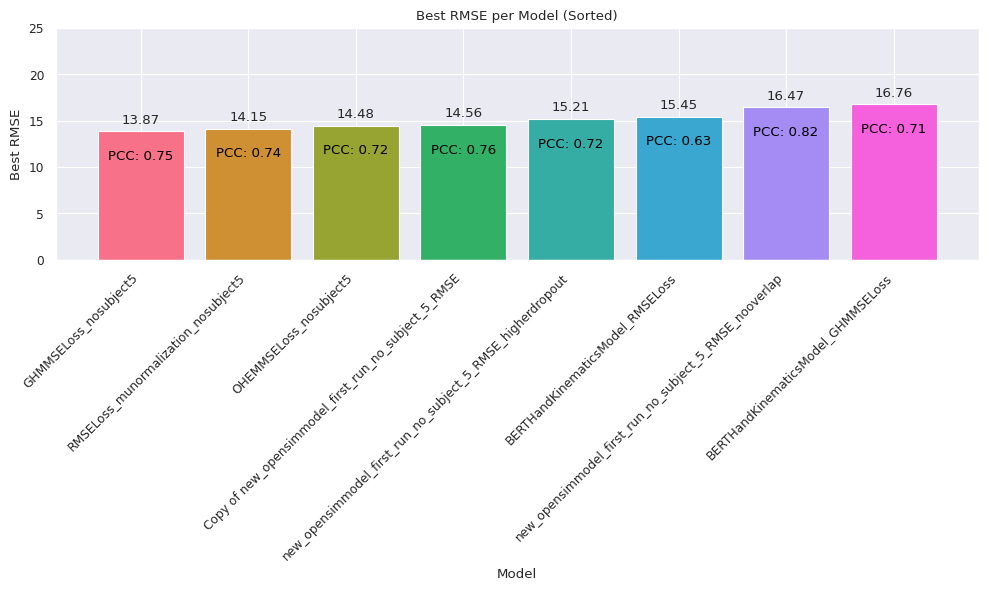

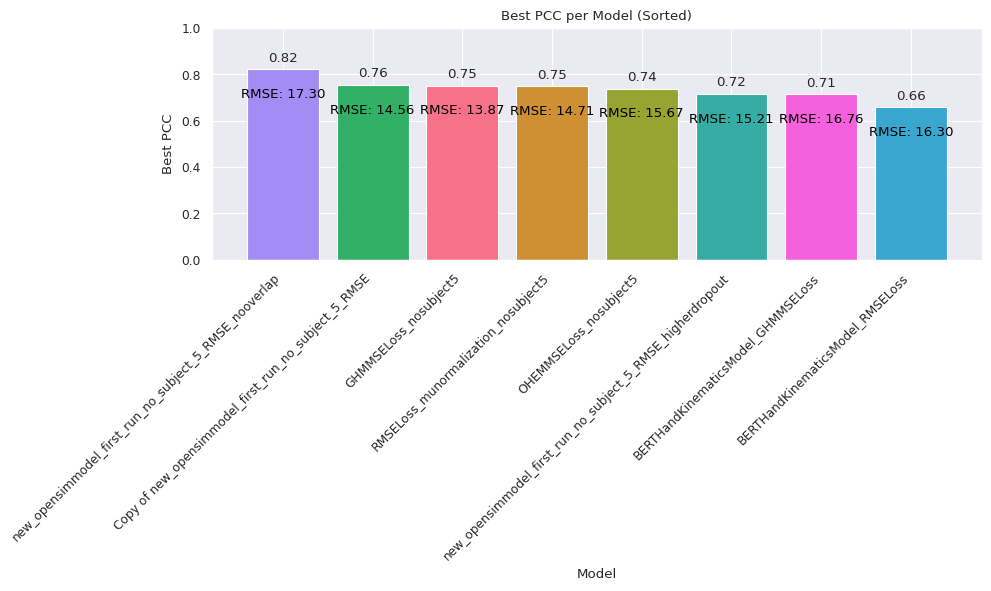

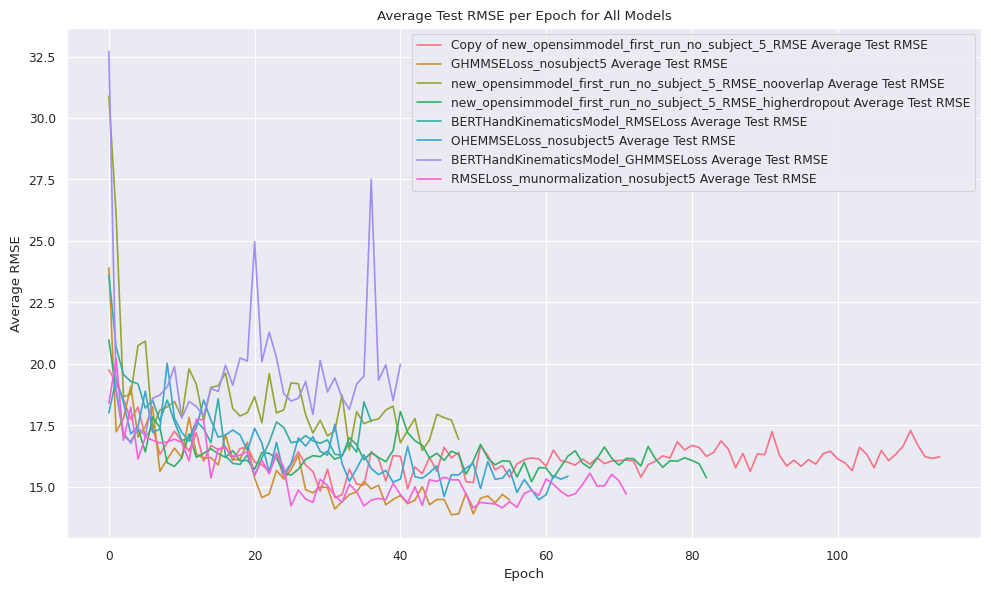

In [8]:
def plot_comparison_bar_graphs_with_limits(aggregated_metrics_dict):
    """Plots two bar graphs comparing the best RMSE and PCC for each model, showing corresponding PCC/RMSE from the same epoch, and plots average test RMSEs."""

    # Dictionary to hold the best RMSE and PCC along with their associated metrics at the same epoch
    best_metrics = {}

    # Iterate through the aggregated metrics and extract the best RMSE and its corresponding PCC, and vice versa
    for model_name, metrics in aggregated_metrics_dict.items():
        # Extract RMSEs and PCCs for the test data
        test_rmses = np.mean(metrics['test_rmses'], axis=1)
        test_pccs = np.mean(metrics['test_pccs'], axis=1)

        # Find the epoch index for the best RMSE and the corresponding PCC at that epoch
        best_rmse_epoch = np.argmin(test_rmses)
        best_rmse = test_rmses[best_rmse_epoch]
        corresponding_pcc_for_best_rmse = test_pccs[best_rmse_epoch]

        # Find the epoch index for the best PCC and the corresponding RMSE at that epoch
        best_pcc_epoch = np.argmax(test_pccs)
        best_pcc = test_pccs[best_pcc_epoch]
        corresponding_rmse_for_best_pcc = test_rmses[best_pcc_epoch]

        # Store in a dictionary for plotting
        best_metrics[model_name] = {
            'best_rmse': best_rmse,
            'corresponding_pcc_for_best_rmse': corresponding_pcc_for_best_rmse,
            'best_pcc': best_pcc,
            'corresponding_rmse_for_best_pcc': corresponding_rmse_for_best_pcc
        }

    # Convert to lists for sorting
    models = list(best_metrics.keys())
    best_rmses = [best_metrics[model]['best_rmse'] for model in models]
    corresponding_pccs = [best_metrics[model]['corresponding_pcc_for_best_rmse'] for model in models]
    best_pccs = [best_metrics[model]['best_pcc'] for model in models]
    corresponding_rmses = [best_metrics[model]['corresponding_rmse_for_best_pcc'] for model in models]

    # Sort by RMSE and PCC
    sorted_by_rmse = sorted(zip(models, best_rmses, corresponding_pccs), key=lambda x: x[1], reverse=False)
    sorted_by_pcc = sorted(zip(models, best_pccs, corresponding_rmses), key=lambda x: x[1], reverse=True)

    # Unpack sorted values
    sorted_models_rmse, sorted_rmses, sorted_pccs_for_rmse = zip(*sorted_by_rmse)
    sorted_models_pcc, sorted_pccs, sorted_rmses_for_pcc = zip(*sorted_by_pcc)

    # Ensure consistent colors across both graphs
    colors = sns.color_palette("husl", len(models))
    model_colors_rmse = {model: colors[i] for i, model in enumerate(sorted_models_rmse)}
    model_colors_pcc = {model: model_colors_rmse[model] for model in sorted_models_pcc}  # Keep the colors consistent

    # Plot RMSE Bar Graph (With Corresponding PCC values)
    plt.figure(figsize=(10, 6))
    bars_rmse = plt.bar(sorted_models_rmse, sorted_rmses, color=[model_colors_rmse[model] for model in sorted_models_rmse])
    plt.title('Best RMSE per Model (Sorted)')
    plt.xlabel('Model')
    plt.ylabel('Best RMSE')
    plt.ylim(0, 25)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add the actual RMSE values and corresponding PCC on top of the bars
    for i, bar in enumerate(bars_rmse):
        yval_rmse = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval_rmse + 0.5, f'{yval_rmse:.2f}', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width()/2, yval_rmse - 2, f'PCC: {sorted_pccs_for_rmse[i]:.2f}', ha='center', va='top', color='black')

    plt.show()

    # Plot PCC Bar Graph (With Corresponding RMSE values)
    plt.figure(figsize=(10, 6))
    bars_pcc = plt.bar(sorted_models_pcc, sorted_pccs, color=[model_colors_pcc[model] for model in sorted_models_pcc])
    plt.title('Best PCC per Model (Sorted)')
    plt.xlabel('Model')
    plt.ylabel('Best PCC')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add the actual PCC values and corresponding RMSE on top of the bars
    for i, bar in enumerate(bars_pcc):
        yval_pcc = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval_pcc + 0.02, f'{yval_pcc:.2f}', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width()/2, yval_pcc - 0.08, f'RMSE: {sorted_rmses_for_pcc[i]:.2f}', ha='center', va='top', color='black')

    plt.show()

    # Plot the average test RMSEs across epochs for each model
    plt.figure(figsize=(10, 6))
    for i, model in enumerate(models):
        avg_test_rmses = np.mean(aggregated_metrics_dict[model]['test_rmses'], axis=1)
        plt.plot(avg_test_rmses, label=f'{model} Average Test RMSE', color=colors[i])

    plt.title('Average Test RMSE per Epoch for All Models')
    plt.xlabel('Epoch')
    plt.ylabel('Average RMSE')
    plt.legend()
    plt.tight_layout()
    plt.show()

# After aggregating the metrics and storing them in aggregated_metrics_dict, call the function
plot_comparison_bar_graphs_with_limits(aggregated_metrics_dict)


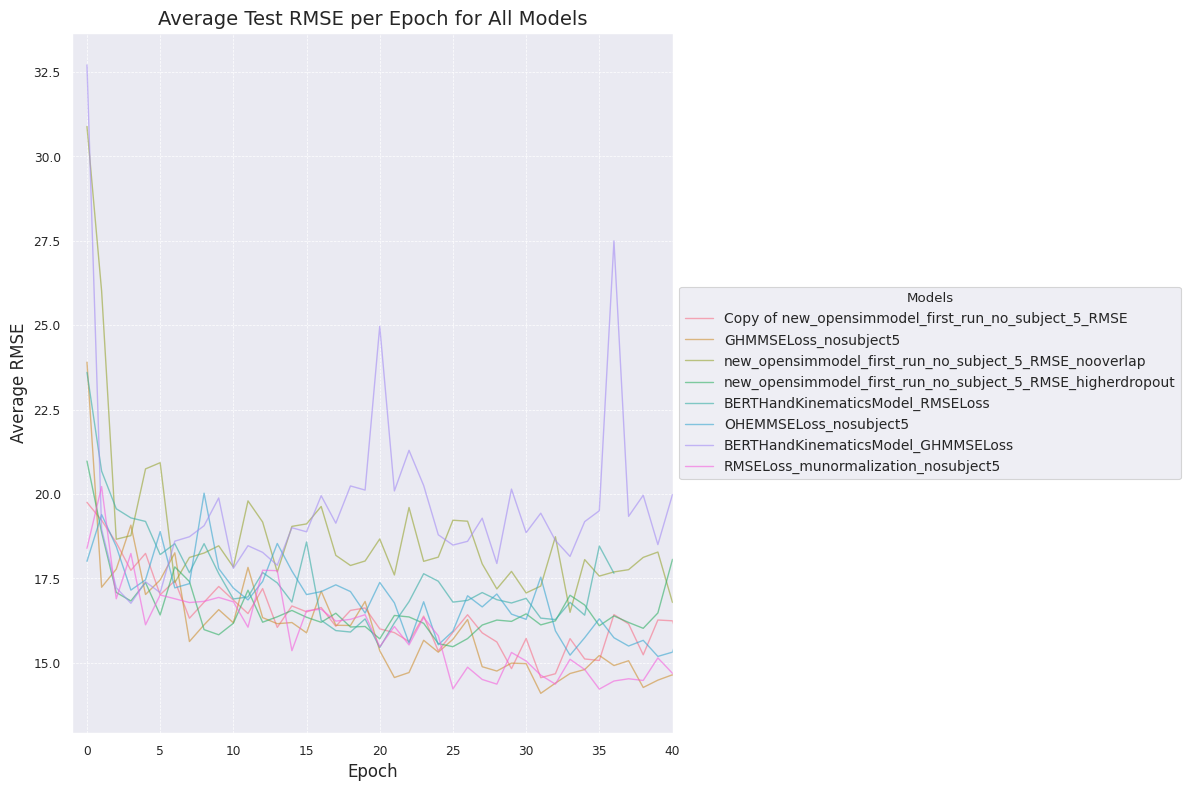

In [15]:
def plot_average_test_rmse_with_readability(aggregated_metrics_dict):
    """Plots the average test RMSE per epoch for each model with thin lines and transparency for better readability."""

    models = list(aggregated_metrics_dict.keys())
    colors = sns.color_palette("husl", len(models))  # Same consistent colors

    plt.figure(figsize=(12, 8))

    # Plot each model's average test RMSE with thinner lines and transparency
    for i, model in enumerate(models):
        avg_test_rmses = np.mean(aggregated_metrics_dict[model]['test_rmses'], axis=1)
        plt.plot(avg_test_rmses, label=model, color=colors[i], linewidth=1, alpha=0.6)  # Thinner lines and alpha transparency

    # Add gridlines to improve readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set plot title and labels
    plt.title('Average Test RMSE per Epoch for All Models', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average RMSE', fontsize=12)

    plt.xlim(-1,40)

    # Move the legend outside the plot to avoid clutter
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Models", fontsize=10)

    # Ensure the plot layout is clean
    plt.tight_layout()

    # Show the plot
    plt.show()

# After aggregating the metrics and storing them in aggregated_metrics_dict, call the function
plot_average_test_rmse_with_readability(aggregated_metrics_dict)
